Load in df data from prev notebook.
* `munge_pt2_disease_hierarchy.ipynb`
*  `df_temp = pd.concat([X,y])
df_temp.to_parquet("features_data_export.parquet")`

Run comparative  evaluation between ml models + output figure

In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.feature_selection import f_classif, chi2,SelectFromModel,SelectKBest,mutual_info_classif, VarianceThreshold
from sklearn.linear_model import LogisticRegression,LogisticRegressionCV, RidgeCV
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score,GroupKFold,cross_validate,StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, classification_report,average_precision_score
from sklearn.feature_selection import SelectFpr, SelectFdr
import re
from sklearn import metrics
from sklearn.metrics import make_scorer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder, OneHotEncoder 
from sklearn.compose import ColumnTransformer

from catboost import Pool, CatBoostClassifier
from scipy.stats import mode
from sklearn.model_selection import StratifiedGroupKFold, GroupKFold, RepeatedStratifiedKFold
from scipy.stats import ttest_rel, chi2, ttest_ind
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, average_precision_score
from sklearn.model_selection import StratifiedKFold, cross_val_predict
import seaborn as sns

from sklearn.metrics import RocCurveDisplay

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, average_precision_score
from sklearn.model_selection import StratifiedKFold, cross_validate, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder

from sklearn import set_config
set_config(transform_output = "pandas")

In [2]:
DO_DL= True
SAVE_CANDIDATES = True#False # save output predicted candidates - overwrites
DO_LEAKY_FS = True#False#True# # leaky train on train feature sel..  - only used during debugging

FASTRUN = False# True
# FASTRUN = True

In [3]:
from re import sub

def prettify_feature_names(s):
    """replace _ with space and camel case and additional changes to make output feature names look nicer"""
    
    s = s.replace("_000000"," ").replace("pct","Percent").replace("dl_","Text Embedding Vector ").replace("ENSG00000","ENSG ")
    s = s.replace("Evidencecount","Evidence count").replace("byDisease","by Disease")
    s = sub(r"(_|-)+", " ", s).title()
    return ''.join(s)

#### Export data

In [4]:
if DO_DL:
    df = pd.read_parquet("features_data_DL_export.parquet")
else: 
    df = pd.read_parquet("features_data_export.parquet") # no deep learning/text features
    
df = df.convert_dtypes(convert_string=False) ## parses ~ 990 floats ot int. Note that memory usage isn't actualy lowered/;
df["has_children"] = df["has_children"].astype(int)

if FASTRUN:
    df = df.sample(frac=0.04)
df

,animal_model,animal_model_ratio_to_smallest,min_phenotype_frequency,known_drug,total_source_cases,genetic_association_ratio_to_biggest,evidenceCount_byDisease_avg,All_ICD_counts,datasource_nunique,genetic_association_ratio_to_smallest,...,dl_759,dl_760,dl_761,dl_762,dl_763,dl_764,dl_765,dl_766,dl_767,has_children
name,,,,,,,,,,,,,,,,,,,,,
10p11.21p12.31 microdeletion syndrome,2,1.0,2,0,4,1.0,8.25,0,3,1.0,...,-0.052247,0.007615,0.003228,-0.043482,0.03513,0.007117,0.005671,0.035386,0.021123,0
10q22.3q23.3 microduplication syndrome,4,1.0,0,0,4,0.0,1.0,0,1,0.0,...,0.001283,0.018512,-0.004181,-0.050078,0.015843,-0.042857,-0.022079,0.036755,-0.017979,0
11p15.4 microduplication syndrome,0,0.0,0,0,0,0.0,0.0,0,0,0.0,...,-0.052197,-0.014921,-0.000551,-0.045029,-0.007862,0.017467,-0.028892,0.029537,0.026184,0
12p12.1 microdeletion syndrome,2,2.0,14,0,3,0.5,1.0,0,2,1.0,...,-0.032878,-0.001697,0.004625,-0.045002,0.041962,0.031034,0.016089,0.051643,0.036005,0
12q14 microdeletion syndrome,169,1.0,0,0,169,0.0,1.177515,0,1,0.0,...,-0.03349,-0.008628,0.001113,-0.062398,0.027995,0.015936,0.017756,0.067076,0.049477,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zygodactyly type 1,0,0.0,0,0,0,0.0,0.0,0,0,0.0,...,0.034138,-0.040213,-0.009371,0.042589,-0.068829,-0.011363,-0.012568,0.027965,0.025432,0
zygodactyly type 2,0,0.0,0,0,0,0.0,0.0,0,0,0.0,...,0.033994,-0.040495,-0.015365,0.042242,-0.060812,-0.008457,-0.012942,0.023673,0.018475,0
zygodactyly type 3,0,0.0,0,0,1,1.0,1.0,0,1,1.0,...,0.036358,-0.041362,-0.006218,0.040948,-0.044446,-0.016768,-0.009939,0.017447,0.022398,0


In [5]:
%%time
if DO_LEAKY_FS or FASTRUN:
    K_Feats = 5 if FASTRUN else 3500
    ## leaky FS 
    # fs = SelectFpr(score_func=chi2,alpha=0.25)
    fs = Pipeline([ ("var",VarianceThreshold(0.0005)),
        ("SimpleImputer",SimpleImputer(strategy="most_frequent")),
#         ("statf",SelectFpr(score_func= f_classif,alpha=0.01)),
#           ("statk",SelectKBest(score_func= f_classif,k=K_Feats))
                  ])
    X = df.drop(columns="has_children").select_dtypes("number")
    X.columns = X.columns.astype(str)
    X.fillna(0,inplace=True)
    y = df["has_children"]
    fs.fit(X,y)
    ##LEAKY!!!: 
    print("pre filt",df.shape) # 4182
    df = df.filter(["source","has_children","Phenotype_counts"]+list(fs.get_feature_names_out()),axis=1)
    df = df.loc[:,~df.columns.duplicated()].copy() # drop a col getting duplicated  Phenotype_counts
    X = X.filter(["source","Phenotype_counts"]+list(fs.get_feature_names_out()),axis=1)
    print(df.shape)  # 40281

pre filt (17222, 3394)
(17222, 3185)
CPU times: user 2.03 s, sys: 627 ms, total: 2.65 s
Wall time: 2.65 s


In [6]:
df

,value_HP_0002866,value_HP_0200034,value_HP_0200097,dl_389,dl_412,score_ENSG00000169032,score_ENSG00000196218,known_drug_ratio_to_smallest,value_HP_0012531,value_HP_0000191,...,value_HP_0002216,score_ENSG00000184752,score_ENSG00000166888,dl_415,value_HP_0002367,value_HP_0030799,score_ENSG00000142192,value_HP_0000506,value_HP_0002100,score_ENSG00000151577
name,,,,,,,,,,,,,,,,,,,,,
10p11.21p12.31 microdeletion syndrome,0,0,0,0.010051,-0.01205,0.0,0.0,0.0,0,0,...,0,0.0,0.0,-0.011187,0,0,0.0,0,0,0.0
10q22.3q23.3 microduplication syndrome,0,0,0,-0.022429,-0.008709,0.0,0.0,0.0,0,0,...,0,0.0,0.0,-0.037797,0,0,0.0,0,0,0.0
11p15.4 microduplication syndrome,0,0,0,-0.011701,-0.031156,0.0,0.0,0.0,0,0,...,0,0.0,0.0,-0.011134,0,0,0.0,0,0,0.0
12p12.1 microdeletion syndrome,0,0,0,-0.010334,-0.016686,0.0,0.0,0.0,0,0,...,0,0.0,0.0,-0.026904,0,0,0.0,0,0,0.0
12q14 microdeletion syndrome,0,0,0,-0.039875,-0.025995,0.0,0.0,0.0,0,0,...,0,0.0,0.0,-0.017895,0,0,0.0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zygodactyly type 1,0,0,0,-0.030366,0.015306,0.0,0.0,0.0,0,0,...,0,0.0,0.0,-0.006449,0,0,0.0,0,0,0.0
zygodactyly type 2,0,0,0,-0.027267,0.003635,0.0,0.0,0.0,0,0,...,0,0.0,0.0,-0.026212,0,0,0.0,0,0,0.0
zygodactyly type 3,0,0,0,-0.024284,0.003059,0.0,0.0,0.0,0,0,...,0,0.0,0.0,-0.028721,0,0,0.0,0,0,0.0


In [6]:
X = df.drop(columns=["has_children"],errors="ignore")
print(X.shape)
y = df["has_children"]
assert y.dropna().sum()>50
print(y.agg(["count","mean","sum"]).round(2))

assert y.shape[0]==X.shape[0]

(17222, 3184)
count    17222.00
mean         0.34
sum       5848.00
Name: has_children, dtype: float64


In [7]:
# ## OPT: String / categorical feature of disease source. may be leak or bias??
# X["source"] = [i[0] for i in list(X.index.str.split("_",expand=True))]## ORIG before index change with grp#[:,0]
## warning - ordinal instead of OHE encoding
 # useful for running other models
lbl = LabelEncoder().fit(X.source)
cat_col = X.columns.get_loc("source")
X.iloc[:,cat_col]
X.iloc[:,cat_col] = lbl.transform(X.source)
X

,dl_313,value_HP_0000544,value_HP_0000579,dl_138,value_HP_0200042,dl_656,value_HP_0003710,dl_97,dl_333,dl_575,...,dl_42,score_ENSG00000082482,value_HP_0000252,dl_467,score_ENSG00000116062,dl_588,value_HP_0003418,value_HP_0003552,value_HP_0008209,value_HP_0002144
name,,,,,,,,,,,,,,,,,,,,,
10p11.21p12.31 microdeletion syndrome,0.007453,0,0,-0.027387,0,0.007557,0,-0.064759,-0.046786,0.031135,...,0.007891,0.0,0,0.05294,0.0,-0.016077,0,0,0,0
10q22.3q23.3 microduplication syndrome,0.032643,0,0,-0.056375,0,0.015613,0,-0.061694,-0.067614,0.021314,...,0.026391,0.0,0,0.029425,0.0,-0.031089,0,0,0,0
11p15.4 microduplication syndrome,-0.005213,0,0,0.024381,0,-0.013699,0,-0.081098,-0.054125,0.054721,...,0.03707,0.0,0,0.047091,0.0,-0.028836,0,0,0,0
12p12.1 microdeletion syndrome,0.010345,0,0,0.00158,0,0.017615,0,-0.052711,-0.07921,0.040678,...,-0.003132,0.0,0,0.013578,0.0,-0.028337,0,0,0,0
12q14 microdeletion syndrome,0.004971,0,0,0.016646,0,-0.021141,0,-0.023351,-0.089484,0.045484,...,-0.0119,0.0,0,0.007425,0.0,-0.002184,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zygodactyly type 1,-0.019572,0,0,0.026484,0,0.051136,0,-0.007487,-0.041265,0.044633,...,-0.001782,0.0,0,0.069221,0.0,0.00174,0,0,0,0
zygodactyly type 2,-0.032744,0,0,0.036259,0,0.073361,0,-0.006917,-0.041538,0.048621,...,-0.000103,0.0,0,0.052682,0.0,-0.001779,0,0,0,0
zygodactyly type 3,-0.037466,0,0,0.027707,0,0.079513,0,-0.016859,-0.039709,0.045052,...,0.00573,0.0,0,0.074649,0.0,-0.006629,0,0,0,0


* alt: could use repeatedKFold (note that then we wouldn't get per sample multiple predictions trivially);
```
# prepare the cross-validation procedure
cv = RepeatedKFold(n_splits=10, n_repeats=7, random_state=1)
# create model
model = LogisticRegression()
# evaluate model
scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))
```

In [8]:
num_columns = X.select_dtypes(include=['number']).columns.tolist()
cat_columns = X.select_dtypes(include=['object',"string"]).columns.tolist()

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('label', OneHotEncoder(handle_unknown='ignore',min_frequency=2))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_columns),
        ('cat', categorical_transformer, cat_columns)])


* Note: SqtBalanced was out default picked model, as a good prior to imbalanced data. 
    I include results with the default catboost (no weighting) As a contrast, but this was not used when ceating and picking the model initially.  

In [9]:
clf_lr = Pipeline(steps=[('preprocessor', preprocessor),('LogisticRegression',LogisticRegression(max_iter=200))])
clf_rf = Pipeline(steps=[('preprocessor', preprocessor),('RF',RandomForestClassifier(n_jobs=-2))])

clf_cb = CatBoostClassifier(cat_features=["source"],verbose=False,auto_class_weights = "SqrtBalanced", task_type="GPU")   
clf_cb2 = CatBoostClassifier(cat_features=["source"],verbose=False, task_type="GPU")  

In [10]:
cv = StratifiedKFold(n_splits=2 if FASTRUN else 5, random_state=42, shuffle=True)


In [11]:
%%time
# # list of models to evaluate: 
classifiers = {
    'Logistic Regression': clf_lr,
    'Random Forest': clf_rf,
    'CatBoost-base': clf_cb2,
    'CatBoost': clf_cb ## SqrtBalanced
}

# Initialize the data frame to store the results
results_df = pd.DataFrame()
# Define the scoring metrics
scoring = {'roc_auc': make_scorer(roc_auc_score, needs_proba=True),
            'pr_auc': make_scorer(average_precision_score, needs_proba=True)}


for clf_name, clf in classifiers.items():
    print(clf_name)
    # Perform cross-validation
    scores = cross_validate(clf, X, y, cv=cv, scoring=scoring, return_train_score=False)
    
    # Store the results into the data frame
    results_df.loc[clf_name, 'ROCAUC Mean'] = scores['test_roc_auc'].mean()
    results_df.loc[clf_name, 'ROCAUC SD'] = scores['test_roc_auc'].std()
    results_df.loc[clf_name, 'PRAUC Mean'] = scores['test_pr_auc'].mean()
    results_df.loc[clf_name, 'PRAUC SD'] = scores['test_pr_auc'].std()


###############################    
### baseline models
clf_name = "Source Baseline"
scores = cross_validate(LogisticRegression(), OneHotEncoder(handle_unknown='ignore',min_frequency=2).fit_transform(X[["source"]]), y, cv=cv, scoring=scoring, return_train_score=False, n_jobs=-1)
results_df.loc[clf_name, 'ROCAUC Mean'] = scores['test_roc_auc'].mean()
results_df.loc[clf_name, 'ROCAUC SD'] = scores['test_roc_auc'].std()
results_df.loc[clf_name, 'PRAUC Mean'] = scores['test_pr_auc'].mean()
results_df.loc[clf_name, 'PRAUC SD'] = scores['test_pr_auc'].std()

clf_name = "Phenotype Baseline"
scores = cross_validate(LogisticRegression(), numeric_transformer.fit_transform(X[["Phenotype_counts"]]), y, cv=cv, scoring=scoring, return_train_score=False, n_jobs=-1)
results_df.loc[clf_name, 'ROCAUC Mean'] = scores['test_roc_auc'].mean()
results_df.loc[clf_name, 'ROCAUC SD'] = scores['test_roc_auc'].std()
results_df.loc[clf_name, 'PRAUC Mean'] = scores['test_pr_auc'].mean()
results_df.loc[clf_name, 'PRAUC SD'] = scores['test_pr_auc'].std()

try:
    clf_name = "Max Phenotype frequency Baseline"
    scores = cross_validate(LogisticRegression(), numeric_transformer.fit_transform(X[["max_phenotype_frequency"]]), y, cv=cv, scoring=scoring, return_train_score=False, n_jobs=-1)
    results_df.loc[clf_name, 'ROCAUC Mean'] = scores['test_roc_auc'].mean()
    results_df.loc[clf_name, 'ROCAUC SD'] = scores['test_roc_auc'].std()
    results_df.loc[clf_name, 'PRAUC Mean'] = scores['test_pr_auc'].mean()
    results_df.loc[clf_name, 'PRAUC SD'] = scores['test_pr_auc'].std()
except: 
    print("max pheno feature missing")
    
clf_name = "# Siblings Baseline"
scores = cross_validate(LogisticRegression(), numeric_transformer.fit_transform(X[["num_siblings"]]), y, cv=cv, scoring=scoring, return_train_score=False, n_jobs=-1)
results_df.loc[clf_name, 'ROCAUC Mean'] = scores['test_roc_auc'].mean()
results_df.loc[clf_name, 'ROCAUC SD'] = scores['test_roc_auc'].std()
results_df.loc[clf_name, 'PRAUC Mean'] = scores['test_pr_auc'].mean()
results_df.loc[clf_name, 'PRAUC SD'] = scores['test_pr_auc'].std()

###
if not FASTRUN:
    print("Catboost Without Text Features")
    clf_name = "Catboost Without Text Features"
    X2 = X.drop(columns=list(X.columns[X.columns.str.contains("dl_")]),errors="ignore")
    scores = cross_validate(clf_cb, X2, y, cv=cv, scoring=scoring, return_train_score=False)

    results_df.loc[clf_name, 'ROCAUC Mean'] = scores['test_roc_auc'].mean()
    results_df.loc[clf_name, 'ROCAUC SD'] = scores['test_roc_auc'].std()
    results_df.loc[clf_name, 'PRAUC Mean'] = scores['test_pr_auc'].mean()
    results_df.loc[clf_name, 'PRAUC SD'] = scores['test_pr_auc'].std()
#########
results_df = results_df.round(4)*100
results_df.sort_values("ROCAUC Mean",inplace=True)
# Print the result
print(results_df)

if SAVE_CANDIDATES:
    if not FASTRUN: 
        results_df.to_csv("./outputs/Table-1-Known disease subtype models evaluation.csv") # Table-1-Known disease submanifestation prediction.csv

Logistic Regression


/home/ddofer/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/ddofer/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-re

Random Forest
CatBoost-base
CatBoost
Catboost Without Text Features
                                  ROCAUC Mean  ROCAUC SD  PRAUC Mean  PRAUC SD
# Siblings Baseline                     52.35       0.52       35.28      0.32
Source Baseline                         55.86       0.55       37.67      0.26
Phenotype Baseline                      66.42       0.42       44.60      0.34
Max Phenotype frequency Baseline        66.44       0.50       44.31      0.38
Logistic Regression                     81.02       0.58       63.60      1.13
Catboost Without Text Features          85.87       0.53       76.40      0.44
Random Forest                           87.28       0.46       80.55      0.98
CatBoost-base                           89.78       0.43       84.76      0.85
CatBoost                                89.82       0.45       84.81      0.76
CPU times: user 18min 27s, sys: 3min 52s, total: 22min 20s
Wall time: 15min 42s


In [12]:
display(results_df)

,ROCAUC Mean,ROCAUC SD,PRAUC Mean,PRAUC SD
# Siblings Baseline,52.35,0.52,35.28,0.32
Source Baseline,55.86,0.55,37.67,0.26
Phenotype Baseline,66.42,0.42,44.60,0.34
Max Phenotype frequency Baseline,66.44,0.50,44.31,0.38
Logistic Regression,81.02,0.58,63.60,1.13
Catboost Without Text Features,85.87,0.53,76.40,0.44
Random Forest,87.28,0.46,80.55,0.98
CatBoost-base,89.78,0.43,84.76,0.85
CatBoost,89.82,0.45,84.81,0.76


## FIG 2
### output rocauc, prauc for selection of models
* done seperately since we need to rerun anyway , and this way we can easily control which models to use

/home/ddofer/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/ddofer/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-re

baseline


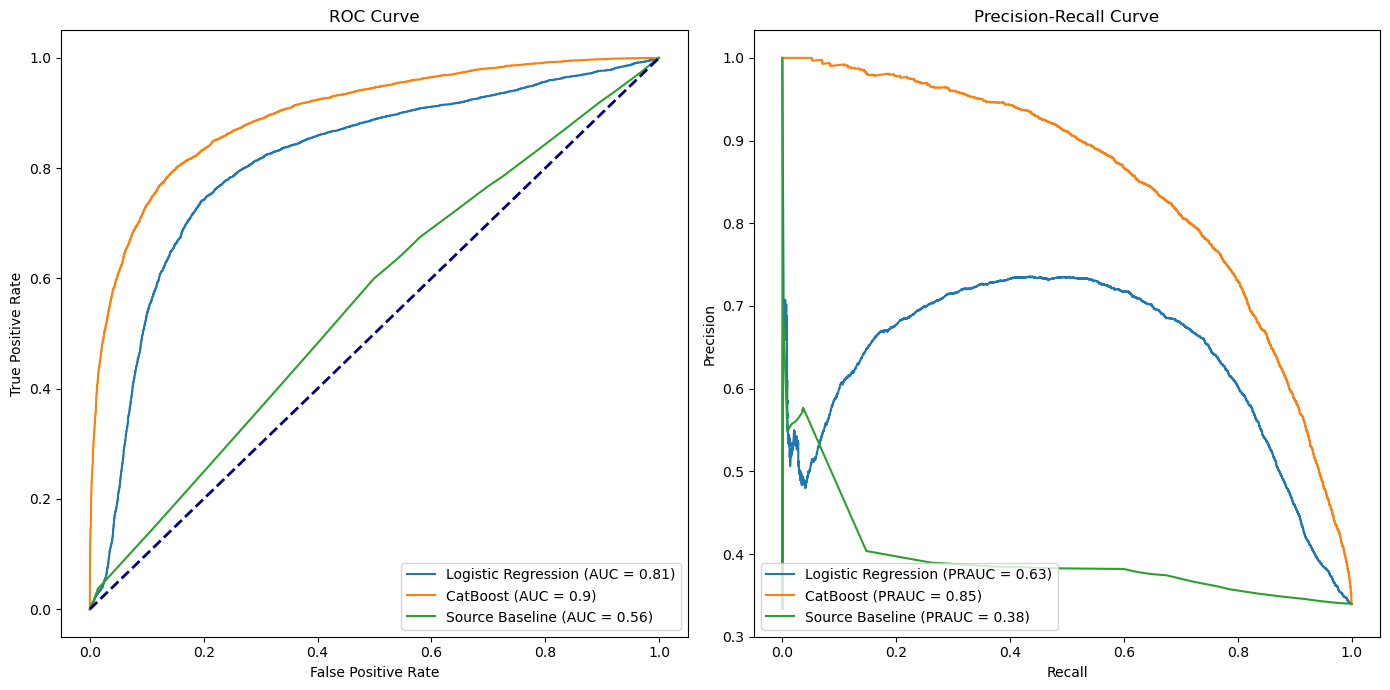

CPU times: user 9min 32s, sys: 2min 15s, total: 11min 47s
Wall time: 6min 2s


In [13]:
%%time
# Assuming clf_lr, clf_rf, clf_cb are predefined classifiers
classifiers = {
    'Logistic Regression': clf_lr,
    'CatBoost': clf_cb # SqrtBalanced
}

# fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(7, 14))
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14, 7))

for clf_name, clf in classifiers.items():
    # Predict probabilities for ROC and PR curves
    y_pred = cross_val_predict(estimator=clf, X=X, y=y, cv=cv, method="predict_proba")[:,1]

    # ROC Curve
    fpr, tpr, _ = roc_curve(y, y_pred)
    auc = (round(roc_auc_score(y, y_pred) , 2))
    ax1.plot(fpr, tpr, label=f'{clf_name} (AUC = {auc})')
    
    # PR Curve
    precision, recall, _ = precision_recall_curve(y, y_pred)
    ap = (round(average_precision_score(y, y_pred), 2))
    ax2.plot(recall, precision, label=f'{clf_name} (PRAUC = {ap})')
print("baseline")
# Baseline Model
clf_name = "Source Baseline"
y_pred = cross_val_predict(estimator=LogisticRegression(), X=OneHotEncoder(handle_unknown='ignore', min_frequency=2).fit_transform(X[["source"]]),
                           y=y, cv=cv, n_jobs=2, method="predict_proba")[:,1]

# ROC Curve
fpr, tpr, _ = roc_curve(y, y_pred)
auc = (round(roc_auc_score(y, y_pred), 2))
ax1.plot(fpr, tpr, label=f'{clf_name} (AUC = {auc})')

# PR Curve
precision, recall, _ = precision_recall_curve(y, y_pred)
ap = (round(average_precision_score(y, y_pred), 2))
ax2.plot(recall, precision, label=f'{clf_name} (PRAUC = {ap})')

# Plot 50 AUC baseline for ROC curve
ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# Configure plots
ax1.set_title('ROC Curve')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.legend(loc='lower right')

ax2.set_title('Precision-Recall Curve')
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.legend(loc='lower left')
plt.tight_layout()

##TODO: not actually saved to output>
if SAVE_CANDIDATES:
    if not FASTRUN:
        plt.savefig('./outputs/Fig-2-roc_pr_curves.png', dpi=840)
        
plt.show()